### Assignment-3 
- Compare Linear Regression Models with Default vs. Custom Parameters for Earthquake Magnitude Prediction
#### Objective
  - Train and analyze two linear regression models to predict earthquake Magnitude: one with default parameters and one with custom-tuned parameters. Compare their performances and interpret findings, and last provide a summary report.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
df = pd.read_csv("preprocessed_earthquake_data.csv")

In [3]:
possible_targets = ['magnitude','Magnitude','mag','Mag','Mw','mw']
target_col = None
for t in possible_targets:
    if t in df.columns:
        target_col = t
        break
if target_col is None:
    numeric_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
    target_col = numeric_cols[-1]

print("Target column selected:", target_col)

Target column selected: Magnitude


In [4]:
y = df[target_col].copy()
X = df.drop(columns=[target_col]).select_dtypes(include=[np.number]).copy()
if X.shape[1] == 0:   # in case no numeric features, do one-hot
    X = pd.get_dummies(df.drop(columns=[target_col]), drop_first=True).select_dtypes(include=[np.number])

# Drop missing rows
data = pd.concat([X, y], axis=1).dropna()
X, y = data[X.columns], data[target_col]

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


In [6]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [7]:
lr_default = LinearRegression().fit(X_train_s, y_train)
ridge_cv = RidgeCV(alphas=np.logspace(-3,2,15), cv=5).fit(X_train_s, y_train)

In [9]:
def evaluate(model, Xtr, Xte, ytr, yte):
    ypred_train = model.predict(Xtr)
    ypred_test = model.predict(Xte)
    rmse_train = np.sqrt(mean_squared_error(ytr, ypred_train))
    rmse_test = np.sqrt(mean_squared_error(yte, ypred_test))
    return {
        "RMSE_train": rmse_train,
        "RMSE_test": rmse_test,
        "MAE_test": mean_absolute_error(yte, ypred_test),
        "R2_test": r2_score(yte, ypred_test)
    }, ypred_test


In [10]:
pip install -U scikit-learn


Defaulting to user installation because normal site-packages is not writeable
  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl (8.7 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
Note: you may need to restart the kernel to use updated packages.


  You can safely remove it manually.


In [13]:
def evaluate(model, Xtr, Xte, ytr, yte):
    ypred_train = model.predict(Xtr)
    ypred_test = model.predict(Xte)
    
    rmse_train = np.sqrt(mean_squared_error(ytr, ypred_train))
    rmse_test = np.sqrt(mean_squared_error(yte, ypred_test))
    
    return {
        "RMSE_train": rmse_train,
        "RMSE_test": rmse_test,
        "MAE_test": mean_absolute_error(yte, ypred_test),
        "R2_test": r2_score(yte, ypred_test)
    }, ypred_test


In [14]:
metrics_lr, ypred_lr_test = evaluate(lr_default, X_train_s, X_test_s, y_train, y_test)
metrics_ridge, ypred_ridge_test = evaluate(ridge_cv, X_train_s, X_test_s, y_train, y_test)

print("\n=== LinearRegression (default) ===")
print(metrics_lr)
print("\n=== Ridge (tuned) α =", ridge_cv.alpha_, "===")
print(metrics_ridge)



=== LinearRegression (default) ===
{'RMSE_train': np.float64(0.9476263878275467), 'RMSE_test': np.float64(0.9715182250564084), 'MAE_test': 0.7069622562232691, 'R2_test': 0.09145283810382387}

=== Ridge (tuned) α = 3.7275937203149416 ===
{'RMSE_train': np.float64(0.9476277753045121), 'RMSE_test': np.float64(0.9715288154847478), 'MAE_test': 0.7069563864820769, 'R2_test': 0.09143303002239722}


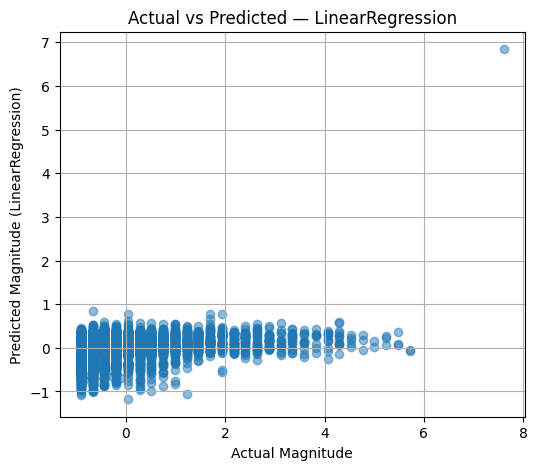

In [15]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, ypred_lr_test, alpha=0.5)
plt.xlabel("Actual Magnitude")
plt.ylabel("Predicted Magnitude (LinearRegression)")
plt.title("Actual vs Predicted — LinearRegression")
plt.grid(True)
plt.show()

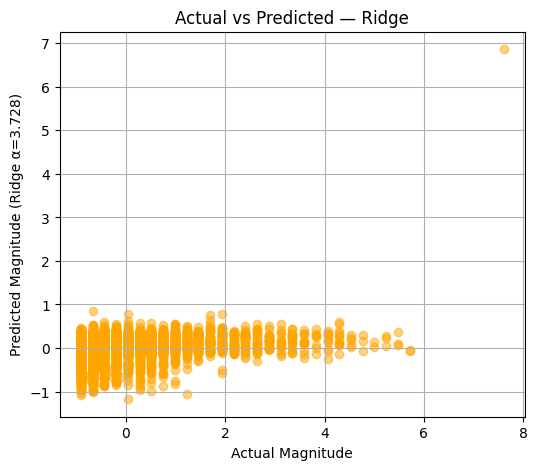

In [16]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, ypred_ridge_test, alpha=0.5, color='orange')
plt.xlabel("Actual Magnitude")
plt.ylabel(f"Predicted Magnitude (Ridge α={ridge_cv.alpha_:.4g})")
plt.title("Actual vs Predicted — Ridge")
plt.grid(True)
plt.show()

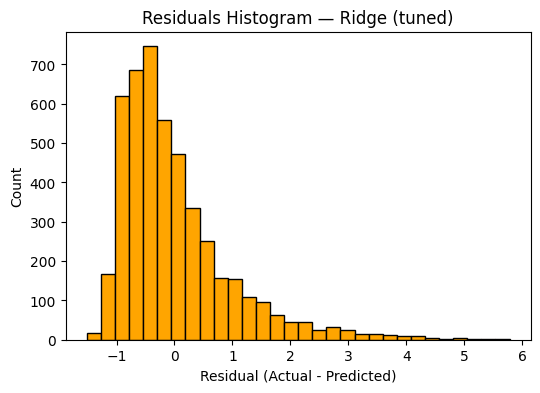

In [17]:
resid_ridge = y_test - ypred_ridge_test
plt.figure(figsize=(6,4))
plt.hist(resid_ridge, bins=30, color="orange", edgecolor="k")
plt.xlabel("Residual (Actual - Predicted)")
plt.ylabel("Count")
plt.title("Residuals Histogram — Ridge (tuned)")
plt.show()

In [18]:
coeffs_lr = pd.Series(lr_default.coef_, index=X.columns).sort_values(key=abs, ascending=False)
coeffs_ridge = pd.Series(ridge_cv.coef_, index=X.columns).sort_values(key=abs, ascending=False)

print("\nTop 10 coefficients — LinearRegression")
print(coeffs_lr.head(10))
print("\nTop 10 coefficients — Ridge")
print(coeffs_ridge.head(10))


Top 10 coefficients — LinearRegression
Magnitude Type_MWW    0.305191
Magnitude Type_MWC    0.267949
Source_US            -0.265501
Magnitude Type_MW     0.244930
Magnitude Type_MWB    0.234741
Source_ISCGEM        -0.217331
Magnitude Type_MS     0.183333
Year                 -0.145429
Source_OFFICIAL       0.106804
Root Mean Square      0.088111
dtype: float64

Top 10 coefficients — Ridge
Magnitude Type_MWW    0.304403
Magnitude Type_MWC    0.267092
Source_US            -0.247374
Magnitude Type_MW     0.244444
Magnitude Type_MWB    0.234097
Magnitude Type_MS     0.183250
Source_ISCGEM        -0.154091
Year                 -0.144457
Source_OFFICIAL       0.108274
Root Mean Square      0.088122
dtype: float64


In [20]:
summary_df = pd.DataFrame({
    "model": ["LinearRegression_default", f"Ridge_alpha_{ridge_cv.alpha_:.4g}"],
    "RMSE_test": [metrics_lr['RMSE_test'], metrics_ridge['RMSE_test']],
    "MAE_test": [metrics_lr['MAE_test'], metrics_ridge['MAE_test']],
    "R2_test": [metrics_lr['R2_test'], metrics_ridge['R2_test']]
})

# Save CSV locally
summary_df.to_csv("linear_models_summary.csv", index=False)

print("✅ Summary saved as 'linear_models_summary.csv' in your project folder.")


✅ Summary saved as 'linear_models_summary.csv' in your project folder.
